### Model Training

Classification Models:
CNN -> (input images and features like bounding boxes)

In [ ]:
import os
import tensorflow as tf
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

from utils.dataset import CandyDataset

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

In [2]:
base_dir = os.getcwd()
dataset_dir = os.path.join(base_dir, 'dataset', '3 - normalized')

dataset = CandyDataset(dataset_dir)
dataset.split_dataset()

- split content to form dataset:
Configurations (data split):

    - Train: 80% 
    - Test: 10%
    - Validation: 10%

In [7]:
train_set_data = dataset.get_images_data(dataset.data_split['train'])
test_set_data  = dataset.get_images_data(dataset.data_split['test'])
validation_set_data  = dataset.get_images_data(dataset.data_split['val'])

train_images = np.array([d['image'] for d in train_set_data])  / 255.0
train_labels = np.array([d['category_id'] - 1 for d in train_set_data])
train_bbox = np.array([d['bbox'] for d in train_set_data])

test_images = np.array([d['image'] for d in test_set_data])  / 255.0
test_labels = np.array([d['category_id'] - 1 for d in test_set_data])
test_bbox = np.array([d['bbox'] for d in test_set_data])

validation_images = np.array([d['image'] for d in validation_set_data])  / 255.0
validation_labels = np.array([d['category_id'] - 1 for d in validation_set_data]) 
validation_bbox = np.array([d['bbox'] for d in validation_set_data])

num_classes = len(np.unique(train_labels)) # calculate number of clases

train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)
validation_labels = to_categorical(validation_labels, num_classes)

print(train_images.shape)
print(train_labels.shape)
print(train_bbox.shape)

print(validation_images.shape)
print(validation_labels.shape)
print(validation_bbox.shape)

(1440, 256, 256, 3)
(1440, 10)
(1440, 4)
(180, 256, 256, 3)
(180, 10)
(180, 4)


- As seen previously, the colors and background are very intense for each object, so the model had to learn the common color, saturation, and lightness intensity pixels to classify correctly.

- We encountered some issues with the input shape. Combining images with bounding boxes required us to adjust the dimensions of the entire dataset.

- No mask was used because, despite attempts, the best option would have been to try with an R-CNN.

- We encountered some issues Compiling the code without using a GPU.

- After various tests, the architecture we used was:

1. Kernel = 5 → Window kernel (convolution).
2. Pool = 2 → Detects the highest number of neighboring pixels (most representative pixel).
3. Padding = 'same' → 'same' results in padding with zeros.
4. Activation = 'relu' → Necessary for this task to avoid linearity issues.
5. Input: 3 channels (RGB) and two outputs for the model to identify bounding boxes and the class.



In [ ]:
input_layer = Input(shape=(256, 256, 3))

kernel = (5, 5)
pool = (2, 2)

x = Conv2D(16, kernel, padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=pool)(x)
x = Conv2D(32, kernel, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=pool)(x)
x = Conv2D(64, kernel, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=pool)(x)
x = Conv2D(128, kernel, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=pool)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

bbox_output = Dense(4, name='bbox_output')(x)
class_output = Dense(num_classes, activation='softmax', name='class_output')(x)

model = Model(inputs=input_layer, outputs=[bbox_output, class_output])

model.summary()

In [8]:
model.compile(optimizer='adam',
              loss={'bbox_output': 'mean_squared_error', 'class_output': 'categorical_crossentropy'},
              loss_weights={'bbox_output': 1.0, 'class_output': 1.0},
              metrics={'bbox_output': 'mean_squared_error', 'class_output': 'accuracy'})


In [9]:
history = model.fit(
    x=train_images, 
    y={'bbox_output': train_bbox, 'class_output': train_labels},    
    validation_data=(validation_images, {'bbox_output': validation_bbox, 'class_output': validation_labels}), 
    epochs = 50,
)

2024-09-10 00:32:48.025113: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1132462080 exceeds 10% of free system memory.


Epoch 1/50
45/45 [==============================] - 73s 2s/step - loss: 5442.4976 - bbox_output_loss: 5429.6372 - class_output_loss: 12.8600 - bbox_output_mean_squared_error: 5429.6372 - class_output_accuracy: 0.0944 - val_loss: 1695.3274 - val_bbox_output_loss: 1686.5608 - val_class_output_loss: 8.7664 - val_bbox_output_mean_squared_error: 1686.5608 - val_class_output_accuracy: 0.1167
Epoch 2/50
45/45 [==============================] - 71s 2s/step - loss: 1446.2682 - bbox_output_loss: 1440.5725 - class_output_loss: 5.6954 - bbox_output_mean_squared_error: 1440.5725 - class_output_accuracy: 0.0875 - val_loss: 1214.7560 - val_bbox_output_loss: 1209.6465 - val_class_output_loss: 5.1095 - val_bbox_output_mean_squared_error: 1209.6465 - val_class_output_accuracy: 0.0722
Epoch 3/50
45/45 [==============================] - 66s 1s/step - loss: 1033.6510 - bbox_output_loss: 1027.9498 - class_output_loss: 5.7015 - bbox_output_mean_squared_error: 1027.9498 - class_output_accuracy: 0.0931 - val_l

In [10]:
model.evaluate(
    test_images, 
    {'bbox_output': test_bbox, 'class_output': test_labels}
)

6/6 [==============================] - 1s 222ms/step - loss: 117.2741 - bbox_output_loss: 117.1721 - class_output_loss: 0.1021 - bbox_output_mean_squared_error: 117.1721 - class_output_accuracy: 0.9722


[117.27412414550781,
 117.17205810546875,
 0.1020708754658699,
 117.17205810546875,
 0.9722222089767456]

In [11]:
model.save(os.path.join(base_dir, 'models/cnn_bounding_box_model.h5'))

In [12]:
predicted_bboxes, predicted_classes = model.predict(test_images)
predicted_classes = np.argmax(predicted_classes, axis=1)
true_classes = np.argmax(test_labels, axis=1)

6/6 [==============================] - 2s 221ms/step


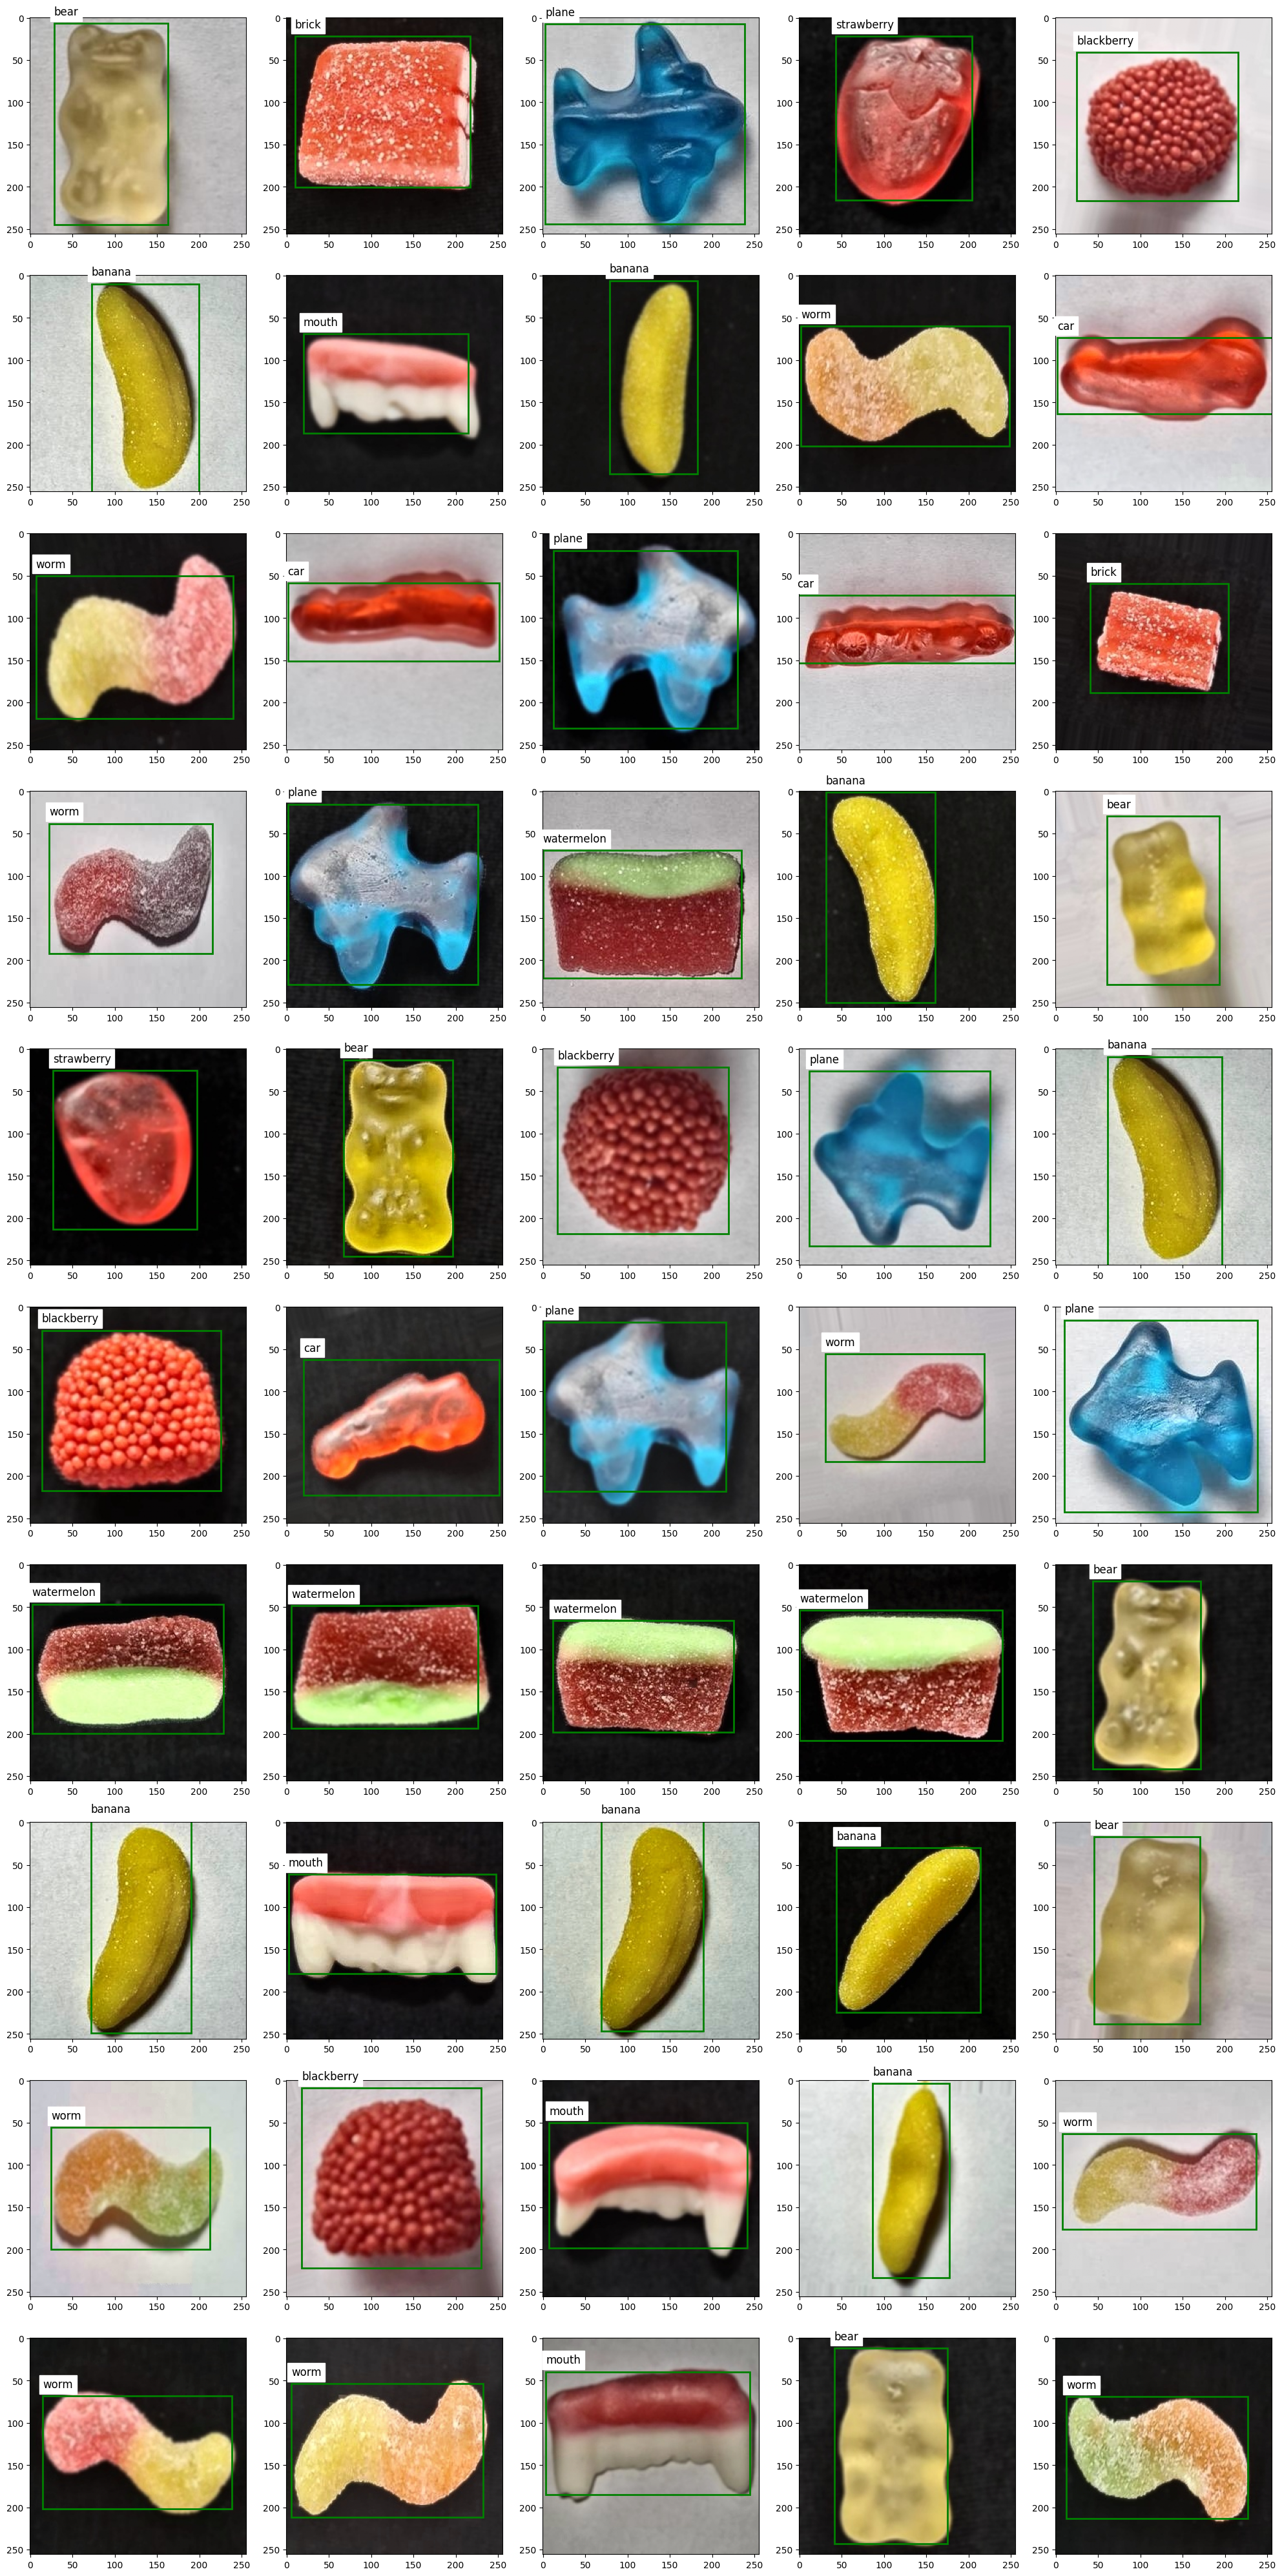

In [13]:

class_labels = ['banana', 'bear','blackberry', 'brick', 'car', 'mouth', 'plane', 'strawberry', 'watermelon', 'worm'] 

def plot_image_with_bbox(image, bbox, predicted_class, class_labels, ax):
    ax.imshow(image)
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                             linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1] - 10, f'{class_labels[predicted_class]}', fontsize=12, backgroundcolor='white')

fig, axes = plt.subplots(10, 5, figsize=(20, 40))
for i, ax in enumerate(axes.flat):
    image = test_images[i]

    bbox = predicted_bboxes[i]
    predicted_class = predicted_classes[i]

    plot_image_with_bbox(image, bbox, predicted_class, class_labels, ax)

plt.tight_layout()
plt.show()


After running our model for 50 epochs, the model produced the following metric results:

 ``` bbox_output_loss: 117.1721 - class_output_loss: 0.1021 - bbox_output_mean_squared_error: 117.1721 - class_output_accuracy: 0.9722```

 - Analysis: Before making any assumptions, it is crucial to evaluate the model's performance by checking the test results. As observed from the metrics presented above, the model was able to correctly identify most cases. However, it is also important to further assess the results by plotting a confusion matrix and calculating the F1 score to properly evaluate the model. 

### 7. Model Evaluation
The performance of the model is evaluated using metrics
such as accuracy, F1-score, and confusion matrix.

In [14]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import numpy as np

accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")

f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9722
F1-Score: 0.9719


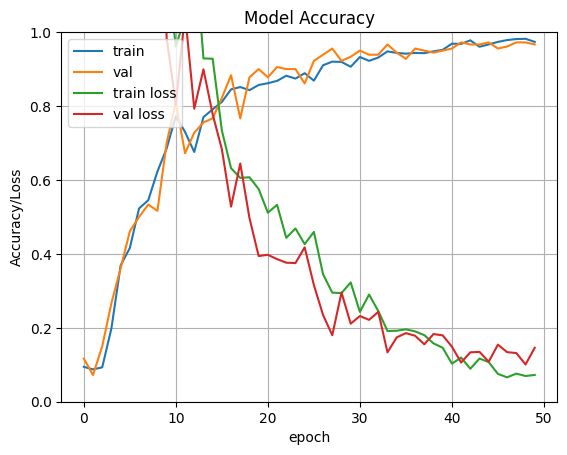

In [18]:
# Accuracy x Epoch plot
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]

plt.plot(history.history['class_output_accuracy'])
plt.plot(history.history['val_class_output_accuracy'])

plt.plot(history.history['class_output_loss'])
plt.plot(history.history['val_class_output_loss'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy/Loss')
plt.xlabel('epoch')

plt.legend(['train', 'val', 'train loss', 'val loss'], loc='upper left')

plt.show()

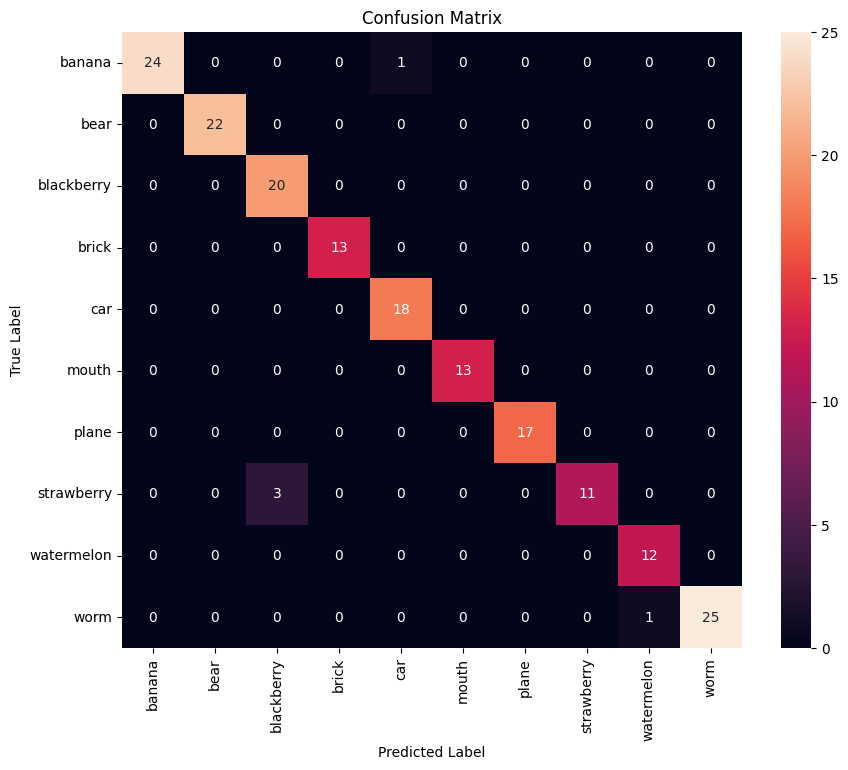

In [16]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

- Conclusion: Although there were some errors, the model demonstrated the ability to generalize and maintain balance. In cases of errors, for example, strawberry and blackberry have more reddish colors and round shapes, which could indeed be a challenge for our model's classification. Both are the only ones with very similar shapes. Overall, we believe that being meticulous with data preprocessing was crucial for achieving these results. We consider the normalization and analysis steps before training the model essential to identify the features of our images and prepare them in the best possible way before training. 
